## Tutorial from Hands-on Machine Learning

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

data   : each row is an element (an image of a hand-written number), and the 784 columns are the pixels intensity (from 0-white to 255-black) of each image

target : the corresponding numeric number to the pixel image 

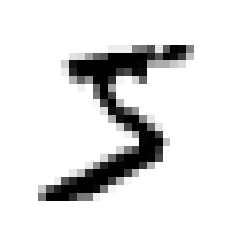

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = mnist['data'].values[0]
digit_image = some_digit.reshape(28,28)

plt.imshow(digit_image,cmap='binary')
plt.axis('off')
plt.show()

See mnist description. Dataset is already split in trainning and test dataset at 60.000

In [5]:
X, y = mnist['data'].values, mnist['target']
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [8]:
for idx in [0,81]:
    rand_digit = mnist['data'].values[idx]
    print(sgd_clf.predict(rand_digit.reshape(1,784)), mnist['target'].values[idx])

[ True] 5
[ True] 0


We see a problem. At index 0, it went well, 5 is correctly predicted. At index 81, the image of 5 is mistaken for a 0.

### Performance Measures


In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Here we have high accuracy (TP + TN) / (TP + TN + FP + FN)

But if we used an dumb estimator that return False all the time, we would still have a 90% accuracy score, because there are only 10% of 5's in the dataset.

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict returns a prediction for each fold (three in this case)

We can use a confusion matrix to evaluate the performance.

It's in the form of :

| Actual         | Predicted Neg | Predicted Pos |
|----------------|---------------|---------------| 
| non-5's images |     TN        |      FP       |
| 5's images     |     FN        |      TP       |

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Then, there are

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

And also the F1 Score ! Which is a harmonic mean between precision and recall

In [12]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Now, let's try to plot the precision recall curves as function of the decision threshold.

Again, we use `cross_val_predict`, but with a method "decision function" in order to return scores

In [13]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [14]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

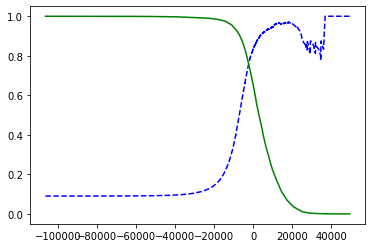

In [15]:
plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
plt.plot(thresholds,recalls[:-1],'g-',label='Recall')
plt.show()



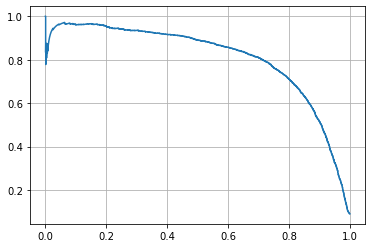

In [16]:
plt.plot(recalls[:-1],precisions[:-1])
plt.grid()
plt.show()

Another metric the ROC (Receiver Operating Characteristic) curve which plot _recall_ (True Positive Rate) in function of _1 - specificity_ (False Positive Rate)

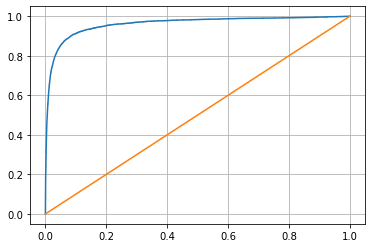

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.grid()
plt.show()


BUT ! A better yet metric would be the AUC (Area Under the Curve) ...

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [20]:
y_scores_forest = y_probas_forest[:,-1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

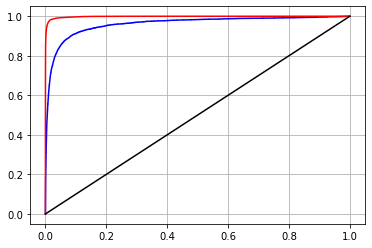

In [21]:
plt.plot(fpr,tpr,'b')
plt.plot(fpr_forest,tpr_forest,'r')
plt.plot([0,1],[0,1],'k')
plt.grid()
plt.show()

The RandomForest Classifier is way better ...

In [22]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

That was a comparison between 2 Binary Classifier

Now, how to implement a multi-class Classification ?

From some (many?) binary classifier, sklearn detects automatically if you have multiple classes

In [23]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)

SVC()

In [24]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

We can access to the score of the decision functions for each class, when predicting `some_digit`

In [25]:
svm_clf.decision_function([some_digit])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

Then, we can also train the sgd classifier on the multi-class problem, instead on just a 5-classifier